# Tutorial 1 in Applied Machine Learning
## Imbalanced Data

This Tutorial will consider different ways of dealing wiht imbalanced data

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve

# 1 Vanilla Implementation of ML

## 1.1 Analysis and Cleaning of Data

We now download data on [credit card fraud detection](https://www.kaggle.com/mlg-ulb/creditcardfraud)

In [3]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

Find how imbalanced the data are.

In [4]:
neg, pos = np.bincount(cleaned_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



Using inbuilt functions in the $scikit$ package normalise the data and divide it into training (60%), validation (20%), and test (20%) sets.

In [5]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.25)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0

val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

Check how the data are distributed  and consider normalising them

In [8]:
cleaned_df[['V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Log Ammount', 'Class']].describe().round(3)


,V1,V2,V3,V4,V5,V26,V27,V28,Log Ammount,Class
count,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000
mean,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,2.942,0.002
std,1.959,1.651,1.516,1.416,1.380,0.482,0.404,0.330,2.024,0.042
min,-56.408,-72.716,-48.326,-5.683,-113.743,-2.605,-22.566,-15.430,-6.908,0.000
25%,-0.920,-0.599,-0.890,-0.849,-0.692,-0.327,-0.071,-0.053,1.723,0.000
50%,0.018,0.065,0.180,-0.020,-0.054,-0.052,0.001,0.011,3.091,0.000
75%,1.316,0.804,1.027,0.743,0.612,0.241,0.091,0.078,4.346,0.000
max,2.455,22.058,9.383,16.875,34.802,3.517,31.612,33.848,10.154,1.000


In [9]:
cleaned_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Log Ammount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.008105
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.989913
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.936641
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.816249
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.248367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,-0.260067
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,3.210481
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,4.217756
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,2.302685


In [10]:
scaler = sklearn.preprocessing.StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (170883,)
Validation labels shape: (56962,)
Test labels shape: (56962,)
Training features shape: (170883, 29)
Validation features shape: (56962, 29)
Test features shape: (56962, 29)


## 1.2 Logistic Regression

Use the $scikit$ logistic regression model to detect credit card fraud.

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
base_log_reg = LogisticRegression().fit(train_features, train_labels)

Plot a confusion matrix of the results

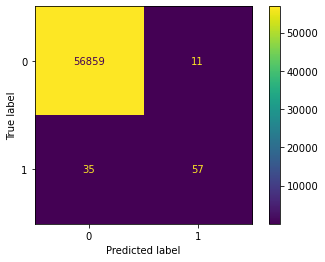

In [13]:
plot_confusion_matrix(base_log_reg, val_features, val_labels)

## 1.3 Random Forests

Use the $scikit$ random forests method to detect credit card fraud.

In [14]:
from sklearn.ensemble import RandomForestClassifier
base_rand_for = RandomForestClassifier().fit(train_features,train_labels)

Plot a confusion matrix of the results


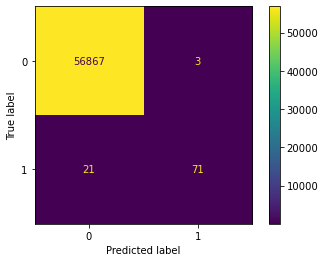

In [15]:
plot_confusion_matrix(base_rand_for, val_features, val_labels)

## 1.4 Neural Networks

Use $TensorFlow$ and $Keras$ to build a two layers networks. The first layer should have 16 nodes and a $relu$ activation function, while the second layer should be one-dimensional with a sigmoid activation. Train the network for 20 epochs.

In [16]:
base_NN = keras.Sequential([
    keras.layers.Dense(
        16, activation='relu',
        input_shape=(train_features.shape[-1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid'),
    ])

base_NN.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.BinaryCrossentropy())

In [17]:
base_history = base_NN.fit(
    train_features,
    train_labels,
    batch_size=2000,
    epochs=40,
    validation_data=(val_features, val_labels), verbose=0)

Text(0, 0.5, 'Loss')

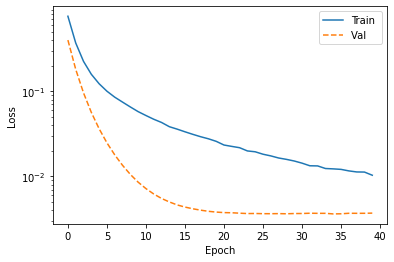

In [18]:
plt.semilogy(base_history.epoch, base_history.history['loss'],
               label='Train ')
plt.semilogy(base_history.epoch, base_history.history['val_loss'],
               label='Val ',
               linestyle="--")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Plot the confusion matrix relative to the NN with the following function

In [19]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap='viridis')
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')


In [20]:
baseline_results = base_NN.predict(val_features)

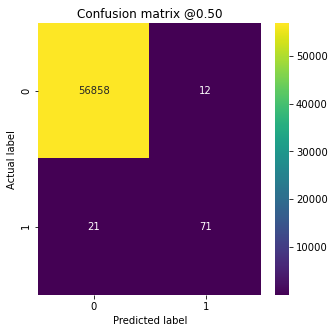

In [21]:
plot_cm(val_labels, baseline_results)

# 2 Imbalanced Data Solutions

There are different ways to improve the accuracy of the models on imbalanced data. We will consider the following
 1. Change of the treshold value on the predicted outcome
 2. Change of weights according to the class
 3. Sampling further data

## 2.1 Change of the Threshold

The output of the models is a value in [0,1] and it can be seen as the probability of the input being a fraudolent transaction. Usually, the threshold for being fraudolent is 0.5, but this value could be modified and its effectiveness is shown with the ROC curves.

### 2.1.1 Logistic Regression
Let's compute the ROC curve to see which threshold works best

In [22]:
fpr, tpr, thr = roc_curve(val_labels,base_log_reg.predict_proba(val_features)[:,1])

In [23]:
areas = np.multiply(tpr,1-fpr)
print('Optimal Threshold: ',thr[np.argmax(areas)],', Optimal Area: ', np.max(areas))

Optimal Threshold:  0.0031501787461101108 , Optimal Area:  0.8765250265670752


Text(0, 0.5, 'True positives [%]')

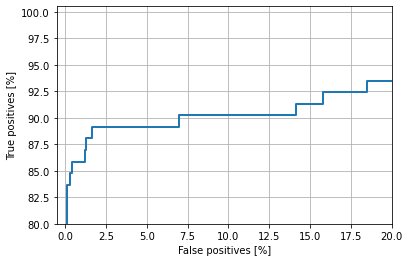

In [24]:
plt.plot(100*fpr, 100*tpr, linewidth=2)
plt.xlim([-0.5,20])
plt.ylim([80,100.5])
plt.grid(True)
plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')

roc_auc_score -> the area under the curve of the actual function <br>
max(areas) -> the auc score of a single point

### 2.1.2 Random Forests
Compute and plot the ROC curve. Which threshold works best?

In [35]:
fpr, tpr, thr = roc_curve(val_labels,base_rand_for.predict_proba(val_features)[:,1])

In [36]:
areas = np.multiply(tpr,1-fpr)
print('Optimal Threshold: ',thr[np.argmax(areas)],', Optimal Area: ', np.max(areas))

Optimal Threshold:  0.01 , Optimal Area:  0.8761136092223454


Text(0, 0.5, 'True positives [%]')

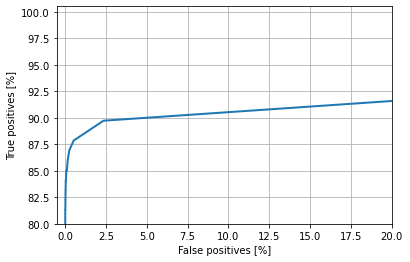

In [37]:
plt.plot(100*fpr, 100*tpr, linewidth=2)
plt.xlim([-0.5,20])
plt.ylim([80,100.5])
plt.grid(True)
plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')

### 2.1.3 NNs
Compute and plot the ROC curve. Which threshold works best?

In [38]:
fpr, tpr, thr = roc_curve(val_labels,base_NN.predict(val_features))

In [39]:
areas = np.multiply(tpr,1-fpr)
print('Optimal Threshold: ',thr[np.argmax(areas)],', Optimal Area: ', np.max(areas))

Optimal Threshold:  0.00031358004 , Optimal Area:  0.8624275394777828


Text(0, 0.5, 'True positives [%]')

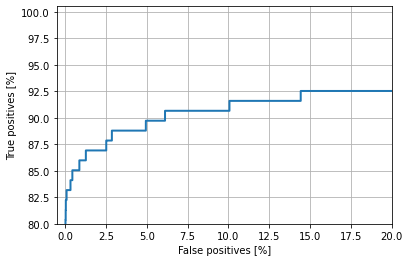

In [40]:
plt.plot(100*fpr, 100*tpr, linewidth=2)
plt.xlim([-0.5,20])
plt.ylim([80,100.5])
plt.grid(True)
plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')

## 2.2 Change of the training weights

We can associate different weights to the loss relative to each class such that the model will give more importance to classifying correctly the unfrequent class.

### 2.2.1 Logistic Recression

Generate a logistic-regression with unbalanced weights.

In [41]:
class_weights = {0:1, 1:100}
weight_log_reg = LogisticRegression(class_weight=class_weights).fit(train_features, train_labels)

Plot a confusion matrix of the results

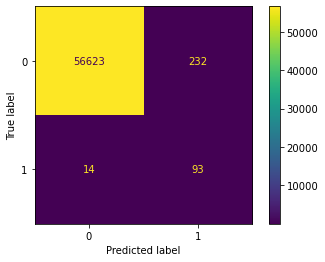

In [59]:
plot_confusion_matrix(weight_log_reg, val_features, val_labels)

### 2.2.2 Random Forests

Train a RF with unbalanced weights.

In [43]:
weight_rand_for = RandomForestClassifier(class_weight=class_weights).fit(train_features,train_labels)

Plot a confusion matrix of the results


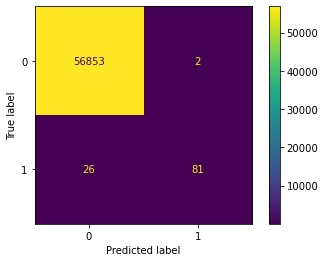

In [60]:
plot_confusion_matrix(weight_rand_for, val_features, val_labels)

### 2.2.3 NNs

Train a NN with the same architecture as before with unbalanced weights.

In [45]:
weight_NN = keras.Sequential([
    keras.layers.Dense(
        16, activation='relu',
        input_shape=(train_features.shape[-1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid'),
    ])

weight_NN.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.BinaryCrossentropy())

In [47]:
weight_NN.fit(
    train_features,
    train_labels,
    batch_size=2000,
    epochs=40,
    validation_data=(val_features, val_labels),
    class_weight=class_weights, verbose=0)

plot confusion matrix

In [57]:
baseline_results = weight_NN.predict(val_features)

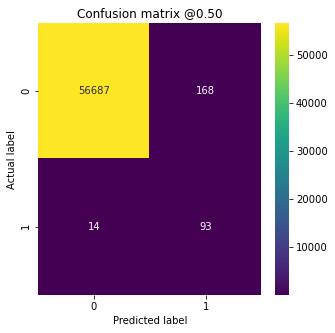

In [58]:
plot_cm(val_labels, baseline_results)

## 2.3 Up Sampling

By using ``numpy``, bootstrap the under-sampled class to get the same number of data for both fraudolent and not credit card transactions.

In [50]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

# sample new positive features

ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

# join the new dataset

resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

### 2.3.1 Logistic Regression

Use the logistic regression on the new up-sampled dataset.

In [51]:
overs_log_reg = LogisticRegression().fit(resampled_features, resampled_labels)

Plot a confusion matrix of the results

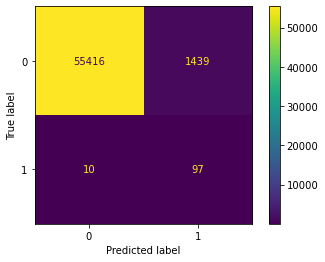

In [61]:
plot_confusion_matrix(overs_log_reg, val_features, val_labels)

### 2.3.2 Random Forests

Train a RF on the new dataset.

In [53]:
over_rand_for = RandomForestClassifier().fit(resampled_features, resampled_labels)

Plot a confusion matrix of the results


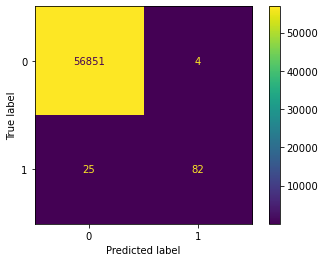

In [62]:
plot_confusion_matrix(over_rand_for, val_features, val_labels)

### 2.3.3 Neural Networks

Train a NN on the new dataset.

In [55]:
over_NN = keras.Sequential([
    keras.layers.Dense(
        16, activation='relu',
        input_shape=(train_features.shape[-1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid'),
    ])

over_NN.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.BinaryCrossentropy())

In [56]:
over_NN.fit(
    resampled_features,
    resampled_labels,
    batch_size=2000,
    epochs=40,
    validation_data=(val_features, val_labels),
    verbose=0)

plot confusion matrix

In [63]:
baseline_results = over_NN.predict(val_features)

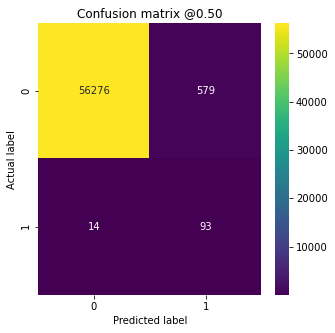

In [64]:
plot_cm(val_labels, baseline_results)

# 3 Compare the different methods performance

Use the validation data to find for each method (lr, RF, NN) the best model (vanilla, weight, over). Then  compare the resulting best methods on the test-data.

## 3.1 Intra-Model

Let's compare how each method compares in each model via the ROC curves

### 3.1.1 Logistic Regression

In [65]:
fpr_base_log, tpr_base_log, _ = roc_curve(val_labels,base_log_reg.predict_proba(val_features)[:,1])
fpr_weight_log, tpr_weight_log, _ = roc_curve(val_labels,weight_log_reg.predict_proba(val_features)[:,1])
fpr_over_log, tpr_over_log, _ = roc_curve(val_labels,overs_log_reg.predict_proba(val_features)[:,1])

Text(0, 0.5, 'True positives [%]')

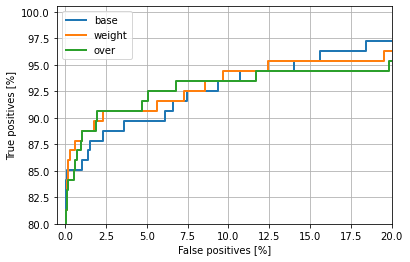

In [66]:
plt.plot(100*fpr_base_log, 100*tpr_base_log, linewidth=2, label='base')
plt.plot(100*fpr_weight_log, 100*tpr_weight_log, linewidth=2, label='weight')
plt.plot(100*fpr_over_log, 100*tpr_over_log, linewidth=2, label='over')
plt.xlim([-0.5,20])
plt.ylim([80,100.5])
plt.grid(True)
plt.legend()
plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')

### 3.1.2 Random Forests

In [67]:
fpr_base_RF, tpr_base_RF, _ = roc_curve(val_labels,base_rand_for.predict_proba(val_features)[:,1])
fpr_weight_RF, tpr_weight_RF, _ = roc_curve(val_labels,weight_rand_for.predict_proba(val_features)[:,1])
fpr_over_RF, tpr_over_RF, _ = roc_curve(val_labels,over_rand_for.predict_proba(val_features)[:,1])

Text(0, 0.5, 'True positives [%]')

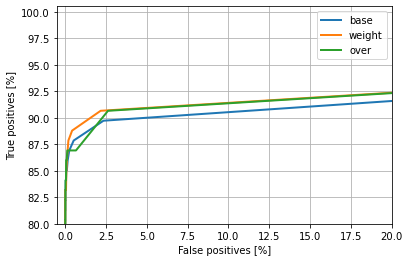

In [68]:
plt.plot(100*fpr_base_RF, 100*tpr_base_RF, linewidth=2, label='base')
plt.plot(100*fpr_weight_RF, 100*tpr_weight_RF, linewidth=2, label='weight')
plt.plot(100*fpr_over_RF, 100*tpr_over_RF, linewidth=2, label='over')
plt.xlim([-0.5,20])
plt.ylim([80,100.5])
plt.grid(True)
plt.legend()
plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')

### 3.1.3 Neural Networks

In [69]:
fpr_base_NN, tpr_base_NN, _ = roc_curve(val_labels,base_NN.predict(val_features))
fpr_weight_NN, tpr_weight_NN, _ = roc_curve(val_labels,weight_NN.predict(val_features))
fpr_over_NN, tpr_over_NN, _ = roc_curve(val_labels,over_NN.predict(val_features))

Text(0, 0.5, 'True positives [%]')

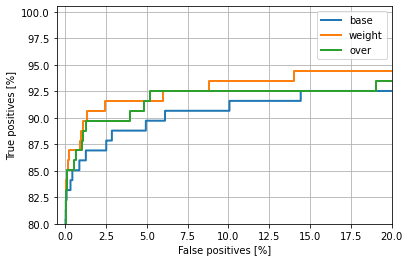

In [70]:
plt.plot(100*fpr_base_NN, 100*tpr_base_NN, linewidth=2, label='base')
plt.plot(100*fpr_weight_NN, 100*tpr_weight_NN, linewidth=2, label='weight')
plt.plot(100*fpr_over_NN, 100*tpr_over_NN, linewidth=2, label='over')
plt.xlim([-0.5,20])
plt.ylim([80,100.5])
plt.grid(True)
plt.legend()
plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')

### 3.2 Inter-Model

Let's compare how the best models compare among themselves.

In [73]:
fpr_over_log, tpr_over_log, _ = roc_curve(test_labels,overs_log_reg.predict_proba(test_features)[:,1])
fpr_over_rand, tpr_over_rand, _ = roc_curve(test_labels,over_rand_for.predict_proba(test_features)[:,1])
fpr_over_NN, tpr_over_NN, _ = roc_curve(test_labels,weight_NN.predict(test_features))

Text(0, 0.5, 'True positives [%]')

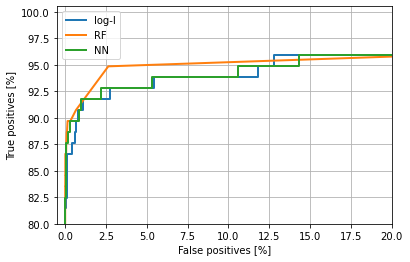

In [74]:
plt.plot(100*fpr_over_log, 100*tpr_over_log, linewidth=2, label='log-l')
plt.plot(100*fpr_over_rand, 100*tpr_over_rand, linewidth=2, label='RF')
plt.plot(100*fpr_over_NN, 100*tpr_over_NN, linewidth=2, label='NN')
plt.xlim([-0.5,20])
plt.ylim([80,100.5])
plt.grid(True)
plt.legend()
plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')